In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
import yfinance as yf

data = yf.download(tickers = "6E=F", start="2017-12-01", end="2023-06-16", interval='1d')
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1.19005,1.19500,1.18600,1.19030,1.19030,289430
2017-12-04,1.18785,1.18875,1.18380,1.18660,1.18660,170174
2017-12-05,1.18755,1.18855,1.18080,1.18230,1.18230,185404
2017-12-06,1.18370,1.18560,1.17880,1.17985,1.17985,197952
2017-12-07,1.18085,1.18210,1.17770,1.17790,1.17790,197235
...,...,...,...,...,...,...
2023-06-09,1.07880,1.07905,1.07475,1.07545,1.07545,230751
2023-06-12,1.07525,1.07945,1.07375,1.07600,1.07600,349852
2023-06-13,1.07600,1.08280,1.07600,1.07935,1.07935,535272


In [3]:
data = data.reset_index('Date', inplace=False)

In [4]:
# 2. Đọc file dữ liệu giá vàng GC=F và chia train test validate theo tỉ lệ 7:2:1
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [6]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
#y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
#y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# Chọn kernel tốt nhất
kernels = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared(), DotProduct()]
param_grid = {'kernel': kernels}

gpr = GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=KFold(n_splits=5))

grid_search.fit(x_train, y_train)


print("Best Kernel:", grid_search.best_estimator_.kernel)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/mode

Best Kernel: RationalQuadratic(alpha=1, length_scale=1)
Best Score: -0.9564883167662435


In [8]:
# Tạo mô hình GPR
kernel = RationalQuadratic(alpha=1, length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)


In [9]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         random_state=42)

In [10]:
y_pred = gpr.predict(x_test)

In [11]:
y_pred_val =  gpr.predict(x_val)

In [12]:
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gpr.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1.1693696  1.1693664  1.1693632  1.16936002 1.16935685 1.16935368
 1.16935053 1.16934739 1.16934427 1.16934115 1.16933804 1.16933494
 1.16933186 1.16932878 1.16932572 1.16932267 1.16931962 1.16931659
 1.16931357 1.16931056 1.16930756 1.16930457 1.16930159 1.16929862
 1.16929566 1.16929271 1.16928977 1.16928684 1.16928392 1.16928101]


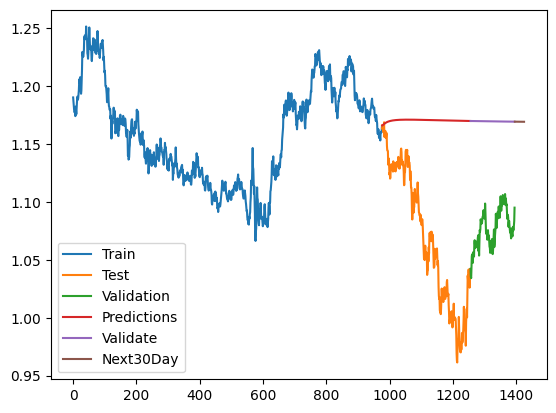

In [13]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()